<a href="https://colab.research.google.com/github/1021114Carlos/finance_app/blob/main/Personal_Purchasing_Power.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries

In [ ]:
import pandas as pd
import math
import matplotlib.pyplot as plt

In [ ]:
""" How to increase personal purchasing power and save money (Inflation is ommitted.)
    Title: Know where your money goes -> Be in control of your future.
"""

def get_positive_int(prompt: str):
  while True:
    try:
      value = int(input(prompt))
      if value > 0:
        return value
      # print("Invalid input: enter whole numbers (1, 2, 3, ...,)")
    except ValueError:
      print("Invalid input: enter whole numbers (1, 2, 3, ...,)")

def get_positive_float(prompt: str):
  while True:
    try:
      value = float(input(prompt))
      if value >= 0:
        return value
      print("Invalid input: enter a non-negative number (e.g., 1 or 1.0)")
    except ValueError:
      print("Invalid input: enter numbers only (e.g., 1 or 1.0).")


def get_housing_status():
  while True:
    status = input("Do you rent or own home? enter rent or own ").strip().lower()
    if status in {"own", "rent"}:
      return status.title()
    print("Invalid input. Please type only 'own' or 'rent'.")

def main():
  years =  get_positive_int("Time horizon in years: ")
  total_months = years*12

  housing_status = get_housing_status()
  debts = [housing_status, "Auto Loan", "Credit Card", "Student Loan"]

  savings = 0
  last_available_cash = 0

  for month in range(1, total_months + 1):
    total_monthly_debt = 0

  for item in debts:
    payment = get_positive_float(f"How much is your {item} payment this month? $ ")
    total_monthly_debt += payment

  monthly_after_tax_income = get_positive_float("Take-home apy after tax this month: $ ")

  available_cash = monthly_after_tax_income - total_monthly_debt
  # save % of available cash if it's positive
  if available_cash > 0:
    amount_to_save = get_positive_float("Percentage to Save? : ")
    amount_to_save = amount_to_save/100
    savings += available_cash*0.05

  last_available_cash = available_cash - savings

  print(f"Money remaining for other expenses in the last month: ${last_available_cash:,.3f}")
  print(f"Total savings over {years} years: ${savings:,.3f}")

if __name__ == "__main__":
  main()


Time horizon in years: 1
Do you rent or own home? enter rent or own rent
How much is your Rent payment this month? $ 1999
How much is your Auto Loan payment this month? $ 750
How much is your Credit Card payment this month? $ 450
How much is your Student Loan payment this month? $ 150
Take-home apy after tax this month: $ 4500
Percentage to Save? : 5
Money remaining for other expenses in the last month: $1,093.450
Total savings over 1 years: $57.550


1093.45

Reverse psychology of debt vs investing

Enter CREDIT CARD balance: 10000
Enter CREDIT CARD APR (e.g. 0.18): .18
Minimum payment to reduce principal must be > 150.00
Enter CREDIT CARD monthly payment: 250

Enter AUTO LOAN balance: 15000
Enter AUTO LOAN APR (e.g. 0.07): .07
Enter AUTO LOAN industry-average horizon (years): 10
Required payment to payoff in 10.0 years: 174.16
Enter AUTO LOAN monthly payment (>= required): 180


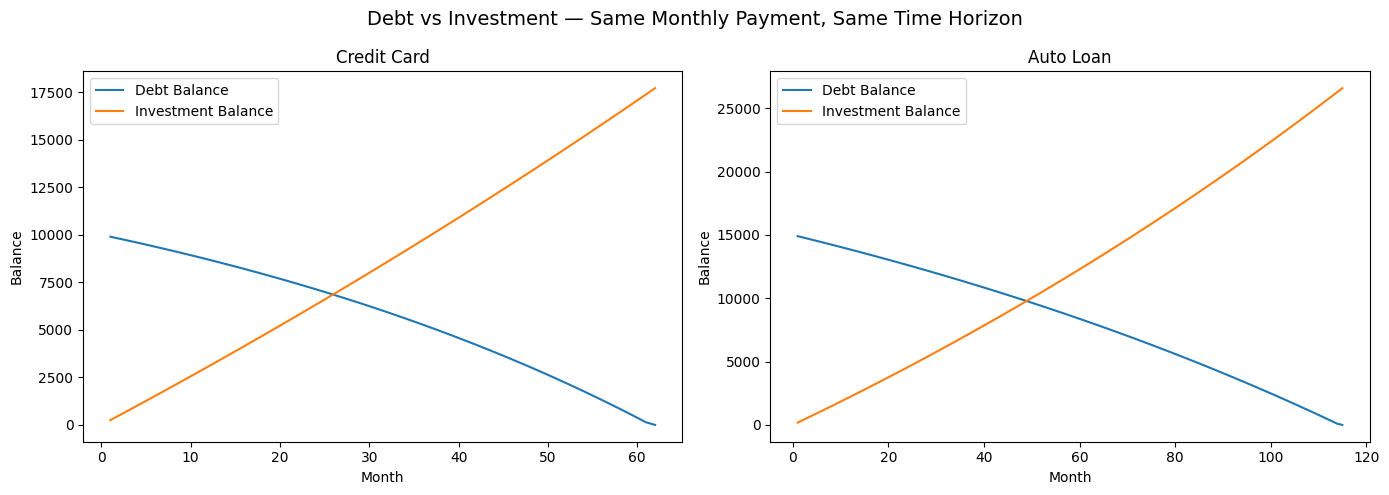


CREDIT CARD RESULTS
Time to payoff: 5 years 2 months
Interest paid (interest only): 5386.23
Investment value at payoff time: 17718.06
Investment interest growth: 2218.06

AUTO LOAN RESULTS
Time to payoff: 9 years 7 months
Interest paid (interest only): 5603.08
Investment value at payoff time: 26597.21
Investment interest growth: 5897.21


In [ ]:
REAL_INVEST_RATE = 0.05
M = 12

def fmt(x: float) -> str:
    return f"{x:.2f}"

def years_months_from_months(total_months: int):
    years = total_months // 12
    months = total_months % 12
    return years, months

def payment_from_pv(pv: float, apr: float, years: float, m: int = 12) -> float:
    r = apr / m
    n = int(round(years * m))
    if n <= 0:
        raise ValueError("years must be > 0")
    if abs(r) < 1e-15:
        return pv / n
    return (r * pv) / (1 - (1 + r) ** (-n))

def simulate_payoff(pv: float, apr: float, pmt: float, m: int = 12):
    """
    Simulates payoff until balance reaches 0.
    Tracks total interest paid and adjusts the LAST payment if it would overpay the balance.
    Returns:
      - df with Month, Debt Balance
      - total_interest_paid
      - total_paid (with last payment adjusted)
    """
    r = apr / m
    bal = pv
    rows = []
    total_interest = 0.0
    total_paid = 0.0
    month = 0

    while bal > 1e-10:
        month += 1
        interest = bal * r
        principal = pmt - interest

        if principal <= 0:
            raise ValueError("Monthly payment is too small to reduce principal; balance will never reach 0.")

        # Adjust final payment if it would overpay the remaining balance
        if principal > bal:
            principal = bal
            pmt_effective = interest + principal
        else:
            pmt_effective = pmt

        bal -= principal
        total_interest += interest
        total_paid += pmt_effective

        rows.append({
            "Month": month,
            "Debt Balance": bal
        })

    return pd.DataFrame(rows), total_interest, total_paid

def investment_schedule_from_zero(monthly_deposit: float, months: int, annual_rate: float, m: int = 12):
    """
    Investment starts at 0.
    Deposit happens at start of each month, then earns interest for that month.
    """
    r = annual_rate / m
    bal = 0.0
    rows = []

    for month in range(1, months + 1):
        bal = (bal + monthly_deposit) * (1 + r)
        rows.append({
            "Month": month,
            "Investment Balance": bal
        })

    return pd.DataFrame(rows)

def run_and_plot(label: str, pv: float, apr: float, pmt: float, ax):
    debt_df, total_interest, total_paid = simulate_payoff(pv, apr, pmt, M)
    months = debt_df.shape[0]

    inv_df = investment_schedule_from_zero(pmt, months, REAL_INVEST_RATE, M)
    df = pd.merge(debt_df, inv_df, on="Month", how="inner")

    ax.plot(df["Month"], df["Debt Balance"], label="Debt Balance")
    ax.plot(df["Month"], df["Investment Balance"], label="Investment Balance")
    ax.set_xlabel("Month")
    ax.set_ylabel("Balance")
    ax.set_title(label)
    ax.legend()

    return df, months, total_interest, total_paid


# =========================
# INPUTS: CREDIT CARD
# =========================
cc_balance = float(input("Enter CREDIT CARD balance: "))
cc_apr = float(input("Enter CREDIT CARD APR (e.g. 0.18): "))

cc_min_payment = cc_balance * (cc_apr / M)
print(f"Minimum payment to reduce principal must be > {fmt(cc_min_payment)}")

cc_payment = float(input("Enter CREDIT CARD monthly payment: "))
if cc_payment <= cc_min_payment:
    raise ValueError("Payment too small to ever pay off the credit card.")

# =========================
# INPUTS: AUTO LOAN
# =========================
car_balance = float(input("\nEnter AUTO LOAN balance: "))
car_apr = float(input("Enter AUTO LOAN APR (e.g. 0.07): "))
car_years_avg = float(input("Enter AUTO LOAN industry-average horizon (years): "))

car_required_payment = payment_from_pv(car_balance, car_apr, car_years_avg, M)
print(f"Required payment to payoff in {car_years_avg} years: {fmt(car_required_payment)}")

car_payment = float(input("Enter AUTO LOAN monthly payment (>= required): "))
if car_payment < car_required_payment:
    raise ValueError("Payment is below required minimum for chosen horizon.")


# =========================
# PLOT: ONE FIGURE, TWO PANELS
# =========================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cc_df, cc_months, cc_total_interest, cc_total_paid = run_and_plot(
    "Credit Card",
    cc_balance,
    cc_apr,
    cc_payment,
    axes[0]
)

car_df, car_months, car_total_interest, car_total_paid = run_and_plot(
    "Auto Loan",
    car_balance,
    car_apr,
    car_payment,
    axes[1]
)

plt.suptitle("Debt vs Investment — Same Monthly Payment, Same Time Horizon", fontsize=14)
plt.tight_layout()
plt.show()


# =========================
# OUTPUTS
# =========================

# CREDIT CARD outputs
cc_years_int, cc_extra_months = years_months_from_months(cc_months)
cc_inv_fv = float(cc_df["Investment Balance"].iloc[-1])
cc_contrib = cc_payment * cc_months
cc_inv_growth = cc_inv_fv - cc_contrib

print("\nCREDIT CARD RESULTS")
print(f"Time to payoff: {cc_years_int} years {cc_extra_months} months")
print(f"Interest paid (interest only): {fmt(cc_total_interest)}")
print(f"Investment value at payoff time: {fmt(cc_inv_fv)}")
print(f"Investment interest growth: {fmt(cc_inv_growth)}")

# AUTO LOAN outputs
car_years_int, car_extra_months = years_months_from_months(car_months)
car_inv_fv = float(car_df["Investment Balance"].iloc[-1])
car_contrib = car_payment * car_months
car_inv_growth = car_inv_fv - car_contrib

print("\nAUTO LOAN RESULTS")
print(f"Time to payoff: {car_years_int} years {car_extra_months} months")
print(f"Interest paid (interest only): {fmt(car_total_interest)}")
print(f"Investment value at payoff time: {fmt(car_inv_fv)}")
print(f"Investment interest growth: {fmt(car_inv_growth)}")


Retirements accounts: 401(K), Traditional and Roth IRA's, (inflation - adjusted returns)

In [ ]:
# 401(k) Future Value Calculator (constant salary, constant contribution rates)
# Assumptions:
# - Salary stays constant at base_salary
# - Contributions are made at the END of each year (ordinary annuity)
# - r is an annual return (as a decimal), compounded annually
# - Total contribution rate = employee_pct + employer_pct

def fv_401k(base_salary, employee_pct, employer_pct, time_horizon_years, annual_return):
    """
    Returns the future value of a 401(k) after T years.

    Parameters
    ----------
    base_salary : float
        Annual salary S
    employee_pct : float
        Employee contribution percentage (e.g., 0.10 for 10%)
    employer_pct : float
        Employer contribution percentage (e.g., 0.04 for 4%)
    time_horizon_years : int
        Time horizon T in years
    annual_return : float
        Annual return r (e.g., 0.07 for 7%)

    Returns
    -------
    float
        Future value at the end of T years
    """
    S = float(base_salary)
    ce = float(employee_pct)
    cm = float(employer_pct)
    T = int(time_horizon_years)
    r = float(annual_return)

    c = ce + cm                 # total contribution rate
    C = c * S                   # annual contribution in dollars

    if T <= 0:
        return 0.0

    # Handle r = 0 separately to avoid division by zero
    if abs(r) < 1e-12:
        return C * T

    # FV of ordinary annuity: C * ((1+r)^T - 1)/r
    FV = C * ((1 + r) ** T - 1) / r
    return FV


def get_float(prompt):
    while True:
        try:
            return float(input(prompt).strip())
        except ValueError:
            print("Please enter a valid number.")


def get_int(prompt):
    while True:
        try:
            return int(input(prompt).strip())
        except ValueError:
            print("Please enter a valid integer.")


if __name__ == "__main__":
    print("\n--- 401(k) Future Value (Constant Salary, End-of-Year Contributions) ---\n")

    base_salary = get_float("Base salary S (e.g., 60,000): ")
    employee_pct = get_float("Employee contribution % (e.g., 10 for 10%): ") / 100
    employer_pct = get_float("Employer contribution % (e.g., 4 for 4%): ") / 100
    T = get_int("Time horizon in years (e.g., 30): ")
    r = get_float("Annual return r % (e.g., 7 for 7%): ") / 100

    fv = fv_401k(base_salary, employee_pct, employer_pct, T, r)

    total_rate = (employee_pct + employer_pct) * 100
    annual_contrib = (employee_pct + employer_pct) * base_salary

    print("\nResults")
    print("-------")
    print(f"Total contribution rate (employee + employer): {total_rate:.2f}%")
    print(f"Annual contribution (C): {annual_contrib:.2f}")
    print(f"Future value after {T} years: {fv:.2f}\n")



--- 401(k) Future Value (Constant Salary, End-of-Year Contributions) ---

Base salary S (e.g., 60000): 60000
Employee contribution % (e.g., 10 for 10%): 6
Employer contribution % (e.g., 4 for 4%): 3
Time horizon T in years (e.g., 30): 25
Annual return r % (e.g., 7 for 7%): 7

Results
-------
Total contribution rate (employee + employer): 9.00%
Annual contribution (C): 5400.00
Future value after 25 years: 341544.80



In [ ]:
a = 541.67*12
a

6500.039999999999